In [1]:

# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats.mstats import winsorize
import xgboost as xgb
from xgboost import XGBRegressor
import joblib

# Configuración para la visualización
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


In [2]:

# Carga de los datos
data_path = '/Users/fernandopradagorge/Documents/Universidad/Master Data Science and AI/Nuclio Projects/Entregables/Entregable_3_Kaggle_31MAR24/ML_Time_Series/ts_kaggle_train.csv'  # Asegúrate de tener la ruta correcta al archivo
df = pd.read_csv(data_path)

# Visualización de las primeras filas del conjunto de datos
df.head()


,Unnamed: 0,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0


In [3]:
# Información general del DataFrame
df.info()

# Estadísticas descriptivas
df.describe()

# Verificación de valores nulos
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14484 entries, 0 to 14483
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             14484 non-null  int64  
 1   date                   14484 non-null  object 
 2   unique_id              14484 non-null  object 
 3   city_id                14484 non-null  int64  
 4   shop_id                14484 non-null  int64  
 5   item_category_id       14484 non-null  int64  
 6   item_id                14484 non-null  int64  
 7   monthly_average_price  13262 non-null  float64
 8   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 1018.5+ KB


Unnamed: 0                  0
date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

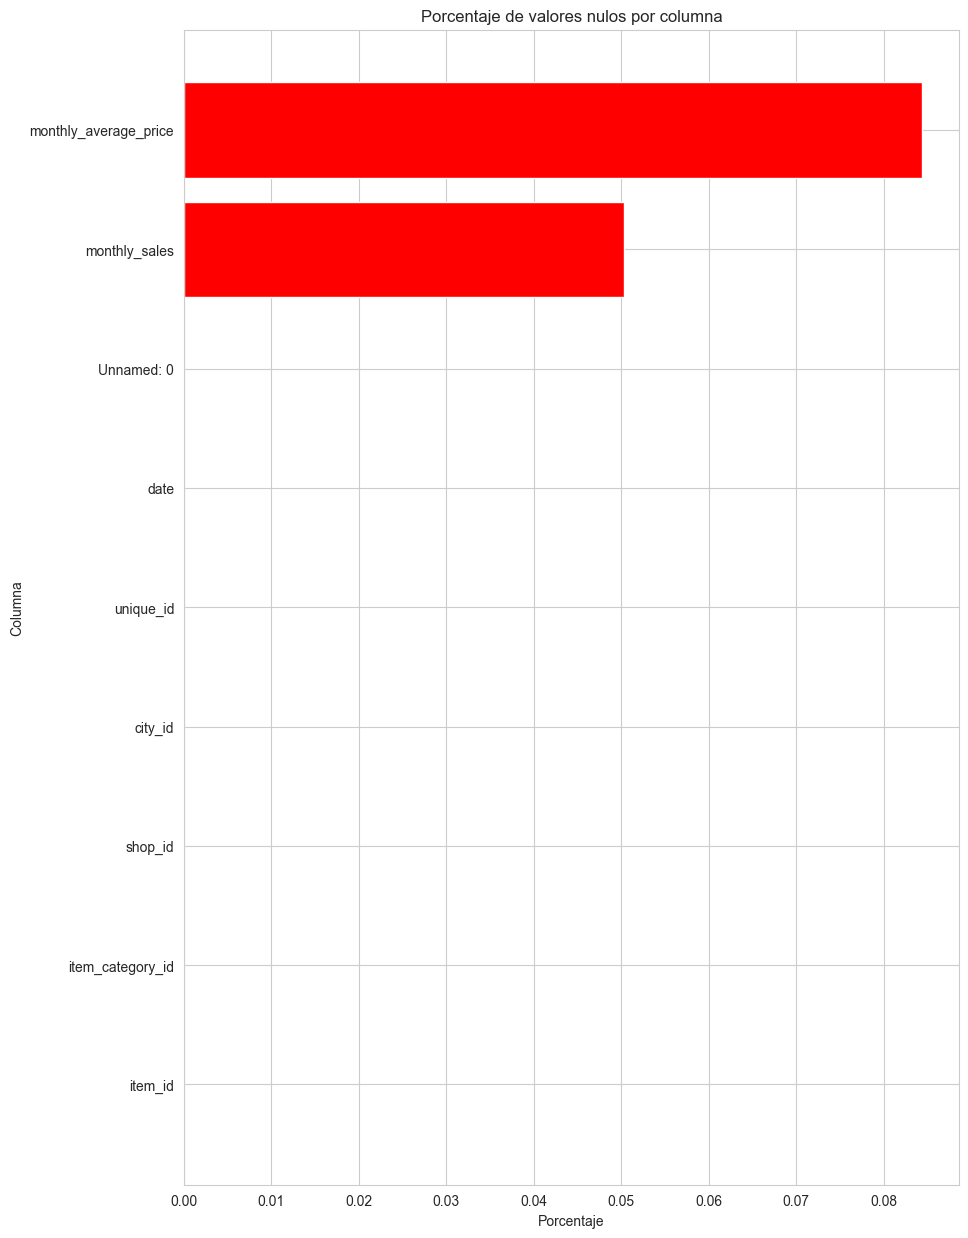

In [4]:
# Aquí trabajamos con los valores nulos. Donde crearé unj gráfico para verlos de manera mas visual
df_null_values = df.isnull().mean().sort_values(ascending=False)

fig, ax= plt.subplots(figsize=(10,15))

#Creo el gráfico de barras horizontales
ax.barh(y= df_null_values.index, #Posiciono las barras según los indices
        width=df_null_values,
        color='red')

# Invierto el eje Y para que las columnas aparezcan en el orden correcto
ax.invert_yaxis()

plt.title('Porcentaje de valores nulos por columna')
plt.xlabel('Porcentaje')
plt.ylabel('Columna')

plt.show()

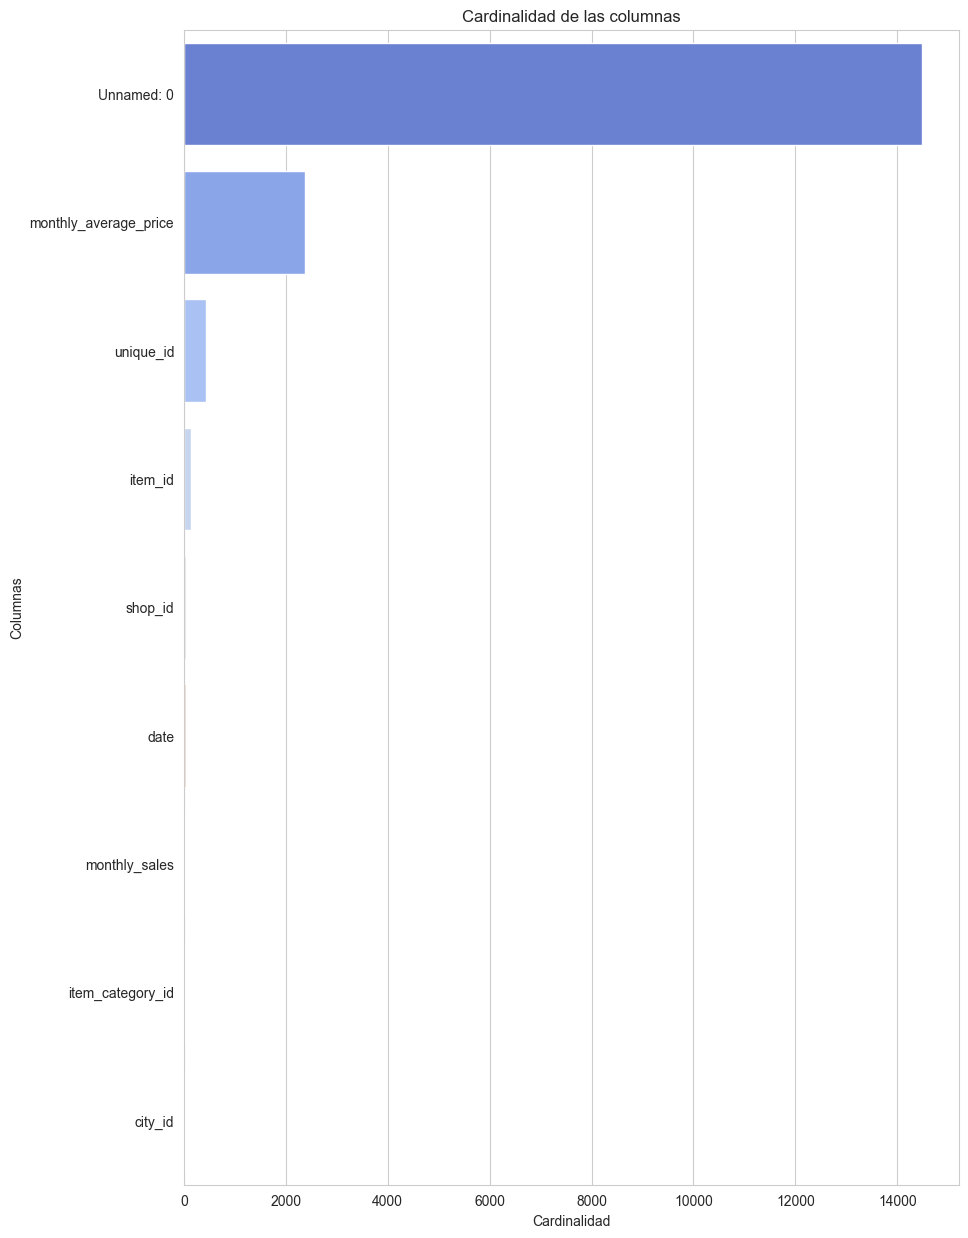

In [5]:
# Calculo la cardinalidad del modelo para tener una mayor compresión de los datos
cardinalidad = df.nunique()
df_cardinalidad = pd.DataFrame({'column': cardinalidad.index, 'cardinalidad': cardinalidad.values})
df_cardinalidad = df_cardinalidad.sort_values(by='cardinalidad', ascending=False)

fig,ax=plt.subplots(figsize= (10,15))
sns.barplot(x='cardinalidad', y='column', data=df_cardinalidad, palette='coolwarm',hue='column', legend=False)

plt.title('Cardinalidad de las columnas')
plt.xlabel('Cardinalidad')
plt.ylabel('Columnas')

plt.show()

In [6]:
df2=df.copy()

In [7]:
# Imputo valores nulos y defino varias tareas a realizar en una Pipeline
num_features = ['monthly_average_price']
cat_features = ['city_id', 'shop_id', 'item_category_id']

#Pipeline para las características numéricas
num_pipe = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

#Pipeline para características categóricas
cat_pipe = Pipeline([
    ('encoder', OrdinalEncoder()),
    ('inputer', KNNImputer(n_neighbors=5))
])

#Combino las pipelines anteriores
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features)
])

#Pipeline final
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror'))
])

In [8]:
df_preprocessed = df.copy()

if 'date' in df_preprocessed.columns:
    df_preprocessed['year'] = pd.to_datetime(df_preprocessed['date']).dt.year
    df_preprocessed['month'] = pd.to_datetime(df_preprocessed['date']).dt.month
    df_preprocessed['day'] = pd.to_datetime(df_preprocessed['date']).dt.day
    df_preprocessed.drop(['date'], axis=1, inplace=True)

if 'unique_id' in df_preprocessed.columns:
    df_preprocessed.drop(['unique_id'], axis=1, inplace=True)

In [9]:
# Aquí voy a trabajar el tema de los Outliers ya que no quiero que desvíen mucho los resultados del modelo.

# Empiezo con esta línea de código me aseguro que todos los valores son positivos, en caso de que haya algún negativo, el método abs() lo transforma en positivo ya que es una función constante
df['monthly_sales'] = df['monthly_sales'] + abs(df['monthly_sales'].min()) +1

# Ahora aplico una transformación logarítmica
df['monthly_sales_log'] = np.log(df['monthly_sales'])

# Una vez hecho lo anterior aplico la winsorization lo que provoca que los valores una limitación en los valores extremos de la distribución.
# Defino primero los límites percentiles para que no coja lo que está fuera de ellos
lower_limit = 0.01  # El 1% más bajo
upper_limit = 0.99  # El 1% más alto

# Aplico winsorization a la columna logarítimica transformada anteriormene
df['monthly_sales_log_winsorized'] = winsorize(df['monthly_sales_log'], limits=(lower_limit, upper_limit))

# Una vez hecha la winsorization aplico una transformación inversa para volver a tener los datos en su escala original
df['monthly_sales_winsorized_retransformed'] = np.exp(df['monthly_sales_log_winsorized'])

# No hay que olvidar restar la constante abs() que añadí al principio para asegurar la positividad
df['monthly_sales_final'] = df['monthly_sales_winsorized_retransformed'] -(abs(df['monthly_sales'].min())+1)

In [10]:
# Añado la columna 'monthly_sales_final' al df.preprocessed para el entrenamiento del modelo
df_preprocessed['monthly_sales_final'] = df['monthly_sales_final'].copy()

In [11]:
# Defino las características (X) y la variable objetivo (y) utilizando el conjunto de datos preprocesado
X = df_preprocessed.drop(['monthly_sales_final'], axis=1)  # Me aseguro de reemplazar 'monthly_sales' con la variable objetivo real
y = df_preprocessed['monthly_sales_final']

# Divido el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Para asegurarme de eliminar los valores NaN de X_train 
cat_cols = [col for col in X_train.columns if X_train[col].dtype=='object']
num_col =[col for col in X_train.columns if col is not cat_cols]

# Convierto las variables categóricas en numéricas
if cat_cols:
    ordinal_encoder = OrdinalEncoder()
    X_train[cat_cols] = ordinal_encoder.fit_transform(X_train[cat_cols])

# Aplico KNN imputer para imputar los valores faltantes en X_train
knn_imputer = KNNImputer(n_neighbors=5)
X_train_imputed = knn_imputer.fit_transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# Verifico que la imputación ha funcionado
print(f'Valores NaN en X_train después de la imputación: {X_train_imputed.isnull().sum().sum()}')

Valores NaN en X_train después de la imputación: 0


In [13]:
# Verifico si hay valores NaN en y_train
print("Valores NaN en y_train:", y_train.isna().sum())

Valores NaN en y_train: 0


In [14]:
print("Valores infinitos antes del tratamiento:", y_train.isin([np.inf, -np.inf]).any())

Valores infinitos antes del tratamiento: False


In [15]:
y_train.fillna(y_train.median(), inplace=True)

In [16]:
print("Valores NaN después de la imputación:", y_train.isnull().any())

Valores NaN después de la imputación: False


In [17]:
# Imputación con un valor fijo
y_train.fillna(0, inplace=True)

In [19]:
# Reemplazo los valores infinitos por NaN para su posterior imputación
#y_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Imputo lo valores NaN con la mediana, incluido los posibles NaN que se hayan imputado en el paso anerior
#y_train.fillna(y_train.median(), inplace=True)

# Hago una verificación para asegurarme que no hay valores NaN ni infinitos
assert not y_train.isnull().any(), "Aún hay valores NaN en y_train después de la imputación."
assert not y_train.isin([np.inf, -np.inf]).any(), "Aún hay valores infinitos en y_train después del tratamiento."

In [20]:
if (y_train <= 0).any():
    y_train +=(abs(y_train.min())+1)

y_train = np.log1p(y_train)

In [21]:
y_train.describe()

count    11587.000000
mean         0.693147
std          0.000000
min          0.693147
25%          0.693147
50%          0.693147
75%          0.693147
max          0.693147
Name: monthly_sales_final, dtype: float64

In [22]:
# Comprobación de Datos
print(f'X_train shape: {X_train_imputed.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'Valores NaN en X_train: {X_train_imputed.isnull().sum().sum()}')
print(f'Valores NaN en y_train: {y_train.isnull().sum()}')

X_train shape: (11587, 10)
y_train shape: (11587,)
Valores NaN en X_train: 0
Valores NaN en y_train: 0


In [23]:
# Optimización de Hiperparámetros
param_grid= {
    'model__n_estimators': [50,100,150], # Número de árboles
    'model__max_depth': [3,6,9], # Profundidad máxima del árbol
    'model__learning_rate': [0.01, 0.1, 0.3], #Tasa de aprendizaje
    'model__subsample': [0.8, 0.9, 1], # Porcentaje de muestras utilizadas para cada árbol
    'model__colsample_bytree':[0.8, 0.9, 1] # Porcentaje de características utilizadas para cada árbol
}

# Inicializo el GridSearchCV
grid_search= GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Entrenamiento usando GridSearchCV
grid_search.fit(X_train_imputed, y_train)

# Mejores hiperparámetros
print("Mejores hipermarámetros:", grid_search.best_params_)

# Mejor puntuación obtenida
print("Mejor puntuación:", grid_search.best_score_)

# Mejor modelo encontrado

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.8; total time=   0.1s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.8; total time=   0.1s[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.8; total time=   0.1s

[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.8; total time=   0.1s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.8; total time=   0.1s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.9; total time=   0.1s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estima

## Entrenamiento del modelo

In [24]:
# Ahora que he sacado los mejores hiperparámetros y el MSE voy a entrenar el modelo XGBoost
best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 50,
    'subsample': 0.8,
    'objective': 'reg:squarederror'
}
final_model = XGBRegressor(**best_params)

# Entreno el modelo con el conjunto completo de datos de entrenamiento
final_model.fit(X_train_imputed, y_train)

# Guardo el modelo por si lo reutilizo mas adelante
joblib.dump(final_model, 'final_model_xgb.joblib')


['final_model_xgb.joblib']

In [25]:
# Filtro las observaciones donde y_test no es NaN
mask = ~y_test.isnull()  # Creo una máscara para las observaciones no NaN
filtered_y_test = y_test[mask]  # Aplico la máscara a y_test

## Evaluación del modelo

In [28]:
# Calcular la mediana de cada columna en X_test
median_X_test = X_test.median()

# Verificar si alguna mediana es NaN
medians_are_nan = median_X_test.isnull().any()

print("¿Alguna mediana en X_test es NaN?:", medians_are_nan)

if medians_are_nan:
    print("Columnas con mediana NaN en X_test:", median_X_test[median_X_test.isnull()].index.tolist())

¿Alguna mediana en X_test es NaN?: False


In [27]:
nan_cols = X_test.columns[X_test.isnull().any()].tolist()
print("Columnas con NaN en X_test:", nan_cols)

Columnas con NaN en X_test: ['monthly_average_price', 'monthly_sales']


In [31]:
# Imputación de valores en X_test usando los valores de X_train
for column in ['monthly_average_price', 'monthly_sales']:
    median_value = X_train[column].median()
    X_test[column].fillna(median_value)

# Verifico de nuevo que no hay valores NaN
assert X_test.isnull().sum().sum() == 0

In [32]:
# Verificamos que no haya NaNs restantes
assert X_train_imputed.isnull().sum().sum() == 0
assert X_test.isnull().sum().sum() == 0

# Entrenamiento del modelo con X_train
final_model.fit(X_train_imputed, y_train)

# Predicciones con X_test
y_pred = final_model.predict(X_test)


In [36]:
# Cálculo de métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

MSE: 2.866747381487812
RMSE: 1.6931471824645996
MAE: 1.6931471824645996
R2: 0.0


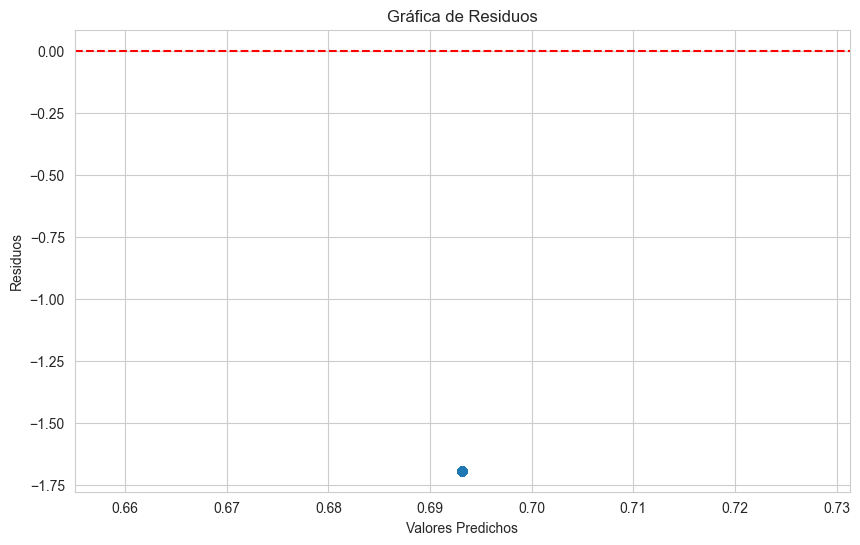

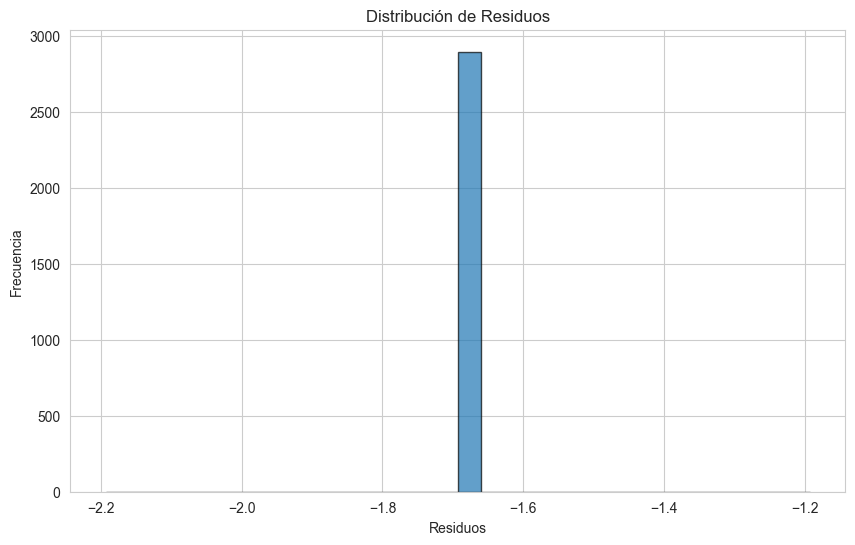

In [38]:
# Sigo con esta celda que me ayuda a analizar los residuos para identificar si hay algún patrón sistemático en los errores del modelo que puedan ser corregidos

# Calculo los residuos
residuos = y_test - y_pred

# Gráfica de residuos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.title('Gráfica de Residuos')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Histograma de los residuos
plt.figure(figsize=(10, 6))
plt.hist(residuos, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

## Observaciones

 Gráfico de residuos:

 Este primer gráfico me muestra las diferencias entre los valores reales y los que ha predicho el modelo. Lo ideal es que estos valores estén dispersos de forma aleatoria alrededor de la línea horizontal y=0 sin formar un patrón claro. Sin embargo, se puede apreciar un patrón en la dispersión de los residuos donde, para valores mas altos, el modelo tiende a sobreestimar las predicciones

 Histograma de residuos:

Muestra a distribución de los residuos. En una situación ideal, este gráfico debería acercarse a una distribución normal con su centro en el 0. La asimetría del modelo indica que se substiman las ventas. También se muestra uun pico pronunciado para un rango de residuos altos, surgiese que hay instancias donde el modelo se equivoca por un margen bastante elevado.